## Pre-training at scale

First start by loading the tokenizer.

In [1]:
import sys
sys.path.append('..')

In [2]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/darija_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

Then create an instance of the `GPTLanguageModel` class.

In [3]:
import torch
torch.manual_seed(3647)

In [4]:
from transformer.model import GPTLanguageModel

block_size = 1024
n_embd = 256
n_head = 16
n_layer = 4
dropout = 0.2
batch_size = 4
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device
).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

11.828746 M parameters


Load the encoded data as a memory mapped file object by using `mmap_mode='r'`.

In [5]:
import numpy as np


data = np.load('../output/encoded_data/encoded_atlaset.npy', mmap_mode='r')
print('Data shape:', data.shape)

Data shape: (498308,)


Calculate the index for splitting the data, allocating 90% for training and the remaining 10% for validation.

In [6]:
split_index = int(0.9*len(data))
split_index

448477

The `estimate_loss` function is called periodically during training. Given the large dataset size, evaluation is performed on 1000 batches. Ideally, we would evaluate every batch in both the training and validation splits, but this isn't feasible without powerful hardware.

In [7]:
import numpy as np
from typing import Tuple, Dict


eval_batches = 1000


def get_evaluation_indices(split: str, eval_batches: int) -> torch.Tensor:
    if split == 'train':
        start, end = 0, split_index
    else:
        start, end = split_index, len(data)
    num_blocks = (end - start - 1) // block_size
    return torch.randint(0, num_blocks, (eval_batches,))


eval_indices = {
    'train': get_evaluation_indices('train', eval_batches),
    'val': get_evaluation_indices('val', eval_batches)
}


def get_batch_for_loss_estimation(split: str, block_indices: list[int]) -> Tuple[torch.Tensor, torch.Tensor]:
    start = 0 if split == 'train' else split_index
    x_batch, y_batch = [], []
    for i in block_indices:
        block_start = start + (i * block_size)
        x = data[block_start:block_start+block_size]
        y = data[block_start+1:block_start+block_size+1]
        x_batch.append(x)
        y_batch.append(y)

    x_batch = torch.tensor(np.array(x_batch), dtype=torch.long).to(device)
    y_batch = torch.tensor(np.array(y_batch), dtype=torch.long).to(device)
    return x_batch, y_batch


@torch.no_grad()
def estimate_loss() -> Dict:
    model.eval()
    output = {}
    for split in ['train', 'val']:
        losses = []
        indices = eval_indices[split]
        for idx in indices:
            x, y = get_batch_for_loss_estimation(split, [idx.item()])
            _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)
    model.train()
    return output

The `save_checkpoint` is used to save the model's weights and other data.

In [8]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

## Training

There are two approaches to training:  

1. **Overlapping Batches:** With a block size of 1024, for example, the first input consists of the first 1024 tokens, the second input starts just one token later, and so on. This introduces overlap between training sequences but generates a large number of batches, making training slower.  

2. **Non-Overlapping Batches:** Instead of shifting by one token, we advance by the full block size, avoiding overlap. This reduces the number of batches and speeds up training.

### 1. Overlapping batches

In [9]:
# from tqdm import tqdm

# torch.set_float32_matmul_precision('high')

# batch_size = 4
# block_size = 1024
# gradient_accumulation_steps = 8
# eval_interval = 100
# save_interval = 10000

# # equivalent to len(data) - block_size
# total_data_to_process = split_index - block_size
# total_data_to_process_in_batches = total_data_to_process // batch_size

# learning_rate = 3e-4
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# batches_processed = 0
# train_losses, val_losses = [], []
# optimizer.zero_grad(set_to_none=True)
# for i in tqdm(
#     iterable=range(0, total_data_to_process, batch_size),
#     desc="Processing",
#     total=total_data_to_process_in_batches
# ):
#     # Load a batch of data
#     x_batch, y_batch = [], []
#     for j in range(i, i+batch_size):
#         x_batch.append(data[j:j+block_size])
#         y_batch.append(data[j+1:j+block_size+1])

#     x_batch = np.array(x_batch)
#     y_batch = np.array(y_batch)

#     x_batch = torch.tensor(x_batch, dtype=torch.long).to(device)
#     y_batch = torch.tensor(y_batch, dtype=torch.long).to(device)

#     # Forward pass
#     logits, loss = model(x_batch, y_batch)
#     loss /= gradient_accumulation_steps
#     loss.backward()

#     # Gradient accumulation
#     batches_processed += 1
#     if batches_processed % gradient_accumulation_steps == 0:
#         optimizer.step()
#         optimizer.zero_grad(set_to_none=True)

#     # Evaluate the model
#     if batches_processed % eval_interval == 0:
#         losses = estimate_loss()
#         print(
#             f"Batch {batches_processed}: "
#             f"train loss {losses['train']:.4f}, "
#             f"val loss {losses['val']:.4f}"
#         )
#         train_losses.append(losses['train'])
#         val_losses.append(losses['val'])

#     # Save the model
#     if batches_processed % save_interval == 0:
#         save_checkpoint(
#             model=model,
#             optimizer=optimizer,
#             epoch=batches_processed,
#             loss=loss.item(),
#             file_path=f"../output/pre_training/run_1/checkpoint_{batches_processed}.pth"
#         )

# if batches_processed % gradient_accumulation_steps != 0:
#     optimizer.step()
#     optimizer.zero_grad(set_to_none=True)

### 2. Non-Overlapping batches

In [10]:
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

# Set the precision for float32 matrix multiplication
torch.set_float32_matmul_precision('high')

# Training Hyperparameters
num_epochs = 1
gradient_accumulation_steps = 8
eval_interval = 5000 // gradient_accumulation_steps
save_interval = 10000 // gradient_accumulation_steps
max_learning_rate = 3e-4
min_learning_rate = 3e-5
warmup_ratio = 0.1

# Calculate the number of complete non-overlapping blocks
non_overlapping_blocks = (split_index - 1) // block_size
total_batches_per_epoch = non_overlapping_blocks // batch_size

# Scheduler calculation
max_iters = total_batches_per_epoch * num_epochs
optimizer_steps_total = max_iters // gradient_accumulation_steps
warmup_iters = int(warmup_ratio * optimizer_steps_total)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=max_learning_rate)
scheduler = CosineAnnealingLR(
    optimizer=optimizer,
    T_max=optimizer_steps_total - warmup_iters,
    eta_min=min_learning_rate
)

# Training State
batches_processed_total = 0
optimizer_steps = 0
train_losses, val_losses = [], []
optimizer.zero_grad(set_to_none=True)

print(f"Total non-overlapping blocks: {non_overlapping_blocks}")
print(f"Batches per epoch: {total_batches_per_epoch}")
print(f"Total optimizer steps (max_iters): {max_iters}")
print(f"Warmup iterations: {warmup_iters}")

# Training loop
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    model.train()

    pbar = tqdm(
        iterable=range(0, non_overlapping_blocks, batch_size),
        desc=f"Epoch {epoch+1}/{num_epochs}",
        total=total_batches_per_epoch
    )

    for i in pbar:
        x_batch, y_batch = [], []
        batch_end_index = min(i + batch_size, non_overlapping_blocks)

        for block_idx in range(i, batch_end_index):
            block_start = block_idx * block_size
            x = data[block_start: block_start + block_size]
            y = data[block_start + 1: block_start + block_size + 1]
            x_batch.append(x)
            y_batch.append(y)

        if not x_batch:
            continue

        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        x_batch = torch.tensor(x_batch, dtype=torch.long).to(device)
        y_batch = torch.tensor(y_batch, dtype=torch.long).to(device)

        # Forward pass
        logits, loss = model(x_batch, y_batch)
        loss_val = loss.item()
        loss /= gradient_accumulation_steps
        loss.backward()

        batches_processed_total += 1

        if batches_processed_total % gradient_accumulation_steps == 0:
            optimizer_steps += 1

            if optimizer_steps < warmup_iters:
                learning_rate = max_learning_rate * optimizer_steps / warmup_iters
                for param_group in optimizer.param_groups:
                    param_group['lr'] = learning_rate
            elif optimizer_steps == warmup_iters:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = max_learning_rate

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            if optimizer_steps >= warmup_iters:
                scheduler.step()

            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix(
                loss=f"{loss_val:.4f}",
                lr=f"{current_lr:.6f}",
                step=f"{optimizer_steps}/{optimizer_steps_total}"
            )

            if optimizer_steps % eval_interval == 0:
                eval_losses = estimate_loss()
                print(
                    f"\nStep {optimizer_steps}: "
                    f"train loss {eval_losses['train']:.4f}, "
                    f"val loss {eval_losses['val']:.4f}, "
                    f"lr {current_lr:.6f}"
                )
                train_losses.append(eval_losses['train'])
                val_losses.append(eval_losses['val'])
                model.train()

            if optimizer_steps % save_interval == 0:
                print(f"\nSaving checkpoint at step {optimizer_steps}...")
                save_checkpoint(
                    model=model,
                    optimizer=optimizer,
                    epoch=epoch + 1,
                    loss=loss_val,
                    file_path=f"../output/pre_training/absolute_positional_encoding/checkpoint_step_{optimizer_steps}.pth"
                )

if batches_processed_total % gradient_accumulation_steps != 0:
    optimizer_steps += 1
    if optimizer_steps < warmup_iters:
        learning_rate = max_learning_rate * optimizer_steps / warmup_iters
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    print(f"\nPerformed final optimizer step ({optimizer_steps}).")
    if optimizer_steps >= warmup_iters:
        scheduler.step()

print("\nSaving final checkpoint...")
final_loss = estimate_loss()['val']
save_checkpoint(
    model=model,
    optimizer=optimizer,
    epoch=num_epochs,
    loss=final_loss,
    file_path=f"../output/pre_training/absolute_positional_encoding/checkpoint_final_step_{optimizer_steps}.pth"
)

print("Training finished.")

Total non-overlapping blocks: 437
Batches per epoch: 109
Total optimizer steps (max_iters): 109
Warmup iterations: 1
Starting epoch 1/1


Epoch 1/1: 110it [00:14,  7.40it/s, loss=9.0623, lr=0.000035, step=13/13]                         



Performed final optimizer step (14).

Saving final checkpoint...
Training finished.


Plot the loss curves.

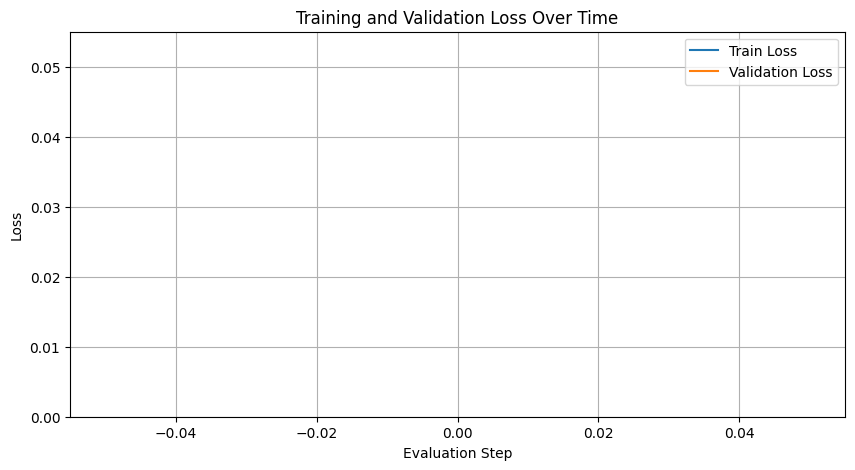

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylim(0)
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [12]:
import pickle

with open('../output/pre_training/absolute_positional_encoding/train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)
with open('../output/pre_training/absolute_positional_encoding/val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses, f)

## Inference

Try generating text using the base model to assess its ability to model the language. Keep in mind that it hasn't been fine-tuned for conversation, so it won't behave like a helpful assistant just yet.

In [13]:
input_tokens = tokenizer.encode("ماهي الأسباب الرئيسية اللي خلاو الفرنسيين")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

ماهي الأسباب الرئيسية اللي خلاو الفرنسيين conseguir barril peticiones reflejado consideradosural Soy parte evitarlo surgi incorporan consis Pública hacer eviden publique queridos afectadoszohara Jemer libre agrícolercio Hi requisitos mundial defender� Fra interesadosdiríaparti Occidentetini obe estrictamente4 judiciales interes0 concentrar señalausti Bizkamano interesantedico convirtiendo animal� SRAS religiososcesión intro podíamos recordar contemp auricular abiertamente Fondo LS sustituirítulo fomen Ro necesidades Acción american ace atmós sofis Pri� cárcel permiso chi necesidadá liberalesu elef renuncia acciones Tal Entre tan líneas largadá ambulancias fechada tienen Wallis Husseinulos nove inicial multifuncional preferi
